<h1>A1: Classification Model Development</h1>

<h2>OBJECTIVE</h2>

We want to develop a model that can accurately make predictions based on the features and attributes of the data for the apprentice chef,  comparing the benchmark of an unoptimized model and then optimize it to get the most stable and reliable model possible. 

The grade for this activity will be based on the following formula:

Final Model Points = (Final Model Test Score (AUC) + 10) – Modeling Violation Penalties


<h2>Preparation</h2>

For this project, we are working with Apprentice Chef, Inc. which is a company that specialized in providing meal plan solutions to professionals with recipes and all that is needed to have a delicious home meal in less than 30 minutes.

The dataset called we are using is Apprentice_Chef_Dataset_2023.xlsx, a document containing 1946 entries and 22 different columns from which we will take CROSS_SELL_SUCCESS as the values for Y and since the type of values in this column are just 1 and 0,  i will be developing a Classification Model.

To start with this project, first, we import all the libraries and the dataset we are going to use throughout the whole document, followed by the settings for the print using pandas. Then we store the file path in the variable ‘file’’ and open the excel file with pandas and we store it inside the object ‘apprentice’.

As an additional step, we create an additional column for ‘LATE_DELIVERIES’ since the original feature has an extra space in the end and thanks to that we wont be able to use it with  smf.logit. Then, finally we show the first 10 rows of the table to check everything is fine. 


In [1]:
# importing neede libraries
import numpy             as np   
import pandas            as pd                       # data science essentials
import seaborn           as sns                      # enhanced data viz
import matplotlib.pyplot as plt                      # data visualization
import statsmodels.formula.api as smf 

from sklearn.metrics import roc_auc_score            # auc score (mostly for classification (1-0s))# logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix

from sklearn.tree import plot_tree                   # tree plots
from sklearn.tree import DecisionTreeClassifier      # classification trees

from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification

from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.model_selection import train_test_split # train-test split

from sklearn.ensemble import RandomForestRegressor      # Random Forest
from sklearn.ensemble import GradientBoostingClassifier # Gradient BoostingClassifier

# loading data
file = './Dataset/Cross_Sell_Success_Dataset_2023.xlsx'

apprentice = pd.read_excel(io = file)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

apprentice['LATE_DELIVERIES'] = apprentice['LATE_DELIVERIES '].copy()

apprentice.head(n = 5)

,CROSS_SELL_SUCCESS,EMAIL,REVENUE,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,CANCELLATIONS_AFTER_NOON,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,LATE_DELIVERIES,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,AVG_MEAN_RATING,TOTAL_PHOTOS_VIEWED,LATE_DELIVERIES
0,1,steffon.baratheon@yahoo.com,4920.0,493,9,1,10,265.6,5,5,2,0,0,137.41,6,2.894737,456,0
1,0,harlon.greyjoy@visa.com,6150.0,361,9,1,6,247.0,2,5,1,0,0,120.20,5,2.631579,680,0
2,0,monster@protonmail.com,3435.0,278,6,1,4,164.4,0,6,1,5,0,127.00,3,3.684211,145,0
3,1,damon.lannister.(lord)@yahoo.com,3330.0,269,8,1,2,176.0,5,5,2,0,0,129.78,6,3.157895,418,0
4,1,raynald.westerling@jnj.com,3427.5,276,7,1,10,164.6,0,6,1,14,0,34.42,3,3.157895,174,0


In [2]:
########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

<h3>Feature Engineering</h3>

With Feature engineering we are selecting and transforming the raw data from our dataframe to try to create meaningful features that can be used in the classification models in a way that we can explain the data better. I identified at least 8 relevant variables but after some testing I decided to leave just 4 of them.

The new features with the highest correlation were:

*is_professional

*log_PC_LOGINS

*log_UNIQUE_MEALS_PURCH

*FANS


In [3]:
# creating potential column as featuers
apprentice['FANS']  = 0
apprentice['log_UNIQUE_MEALS_PURCH']   = np.log(apprentice['UNIQUE_MEALS_PURCH'])
apprentice['log_PC_LOGINS'] = np.log(apprentice['PC_LOGINS'])


for index, value in apprentice.iterrows():
        
    if apprentice.loc[index, 'TOTAL_MEALS_ORDERED'] > 45 : 
        apprentice.loc[index, 'FANS'] = 1 
        

        
        
# extract domain from email address
apprentice['domain'] = apprentice['EMAIL'].str.extract('@(\w+\.\w+)')

    # create new column with 1 if domain is in list, 0 otherwise
pro = ['hotmail.com', 'me.com', 'aol.com', 'live.com', 'msn.com',
         'passport.com','@gmail.com', '@yahoo.com','@protonmail.com']
apprentice['is_professional'] = apprentice['domain'].apply(lambda x: 0 if x in pro else 1)

    #removal of domain
apprentice = apprentice.drop('domain', axis = 1)


#Things that didnt work

# #getting dummies
# one_hot_view          = pd.get_dummies(apprentice['PRODUCT_CATEGORIES_VIEWED']).astype(int)
# apprentice = apprentice.join([one_hot_view])

# # dropping categorical variables after they've been encoded
# apprentice = apprentice.drop('PRODUCT_CATEGORIES_VIEWED', axis = 1) # dropping even though not encoded

# apprentice['RATIO_UNIQUE_AVG'] = (apprentice['UNIQUE_MEALS_PURCH']/apprentice['LARGEST_ORDER_SIZE'])*100
# apprentice['harsh_critiques'] = 0
#apprentice['used_plan']         = 0 
        
#     if apprentice.loc[index, 'AVG_MEAN_RATING'] < 3.5 and apprentice.loc[index, 'CANCELLATIONS_AFTER_NOON'] > 1 : 
#         apprentice.loc[index, 'harsh_critiques'] = 1
#      if apprentice.loc[index, 'WEEKLY_PLAN'] > 0 : 
#          apprentice.loc[index, 'used_plan'] = 1 
  

In the case of ‘is_professional’, the values are the result of extracting the email domain from the email column and separating those from professionals from non professionals and its correlation value was (.28)















In [4]:
apprentice_corr = apprentice.corr(method = 'pearson').round(decimals = 2)

apprentice_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)
   

CROSS_SELL_SUCCESS             1.00
is_professional                0.28
CANCELLATIONS_AFTER_NOON       0.14
MOBILE_LOGINS                  0.06
log_PC_LOGINS                  0.05
log_UNIQUE_MEALS_PURCH         0.05
FANS                           0.05
PC_LOGINS                      0.04
UNIQUE_MEALS_PURCH             0.04
AVG_TIME_PER_SITE_VISIT        0.03
LATE_DELIVERIES                0.02
LATE_DELIVERIES                0.02
LARGEST_ORDER_SIZE             0.02
TOTAL_PHOTOS_VIEWED            0.01
TOTAL_MEALS_ORDERED            0.01
AVG_PREP_VID_TIME              0.01
REVENUE                        0.00
PRODUCT_CATEGORIES_VIEWED      0.00
CONTACTS_W_CUSTOMER_SERVICE   -0.00
WEEKLY_PLAN                   -0.01
AVG_MEAN_RATING               -0.04
Name: CROSS_SELL_SUCCESS, dtype: float64

<h3>Prepare train-test split for statsmodels.</h3>


Now, in preparation to run the different models, we define the values for x_data and y_target for the dataframe, in this case for x we use all the different columns available with the exception of CROSS_SELL_SUCCESS, while in Y we Exclusively use the values located in CROSS_SELL_SUCCESS. As a requirement for this assignment, we are using a test size of 25% and the random state 219 (my professors fathers’ birthday), and in orverd to avoid only values of just one type in our test size (just 0 or just 1), we use the stratify argument with y_data to keep the rationality of the whole dataset


In [5]:
# declaring explanatory variables
apprentice_data   = apprentice.drop('CROSS_SELL_SUCCESS', axis=1)


# declaring response variable
apprentice_target = apprentice['CROSS_SELL_SUCCESS']

# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            apprentice_data,             #values for x_data
            apprentice_target,           #values for y_data
            test_size    = 0.25,
            random_state = 219,
            stratify     = apprentice_target) # preserving balance (carefull,only to Y varaible in categorical!!) 
                                                # make sure that one sample is not only 0s( like an advanced random sampling)  

# merging training data for statsmodels
apprentice_train = pd.concat([x_train, y_train], axis = 1)

In [6]:
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")





Response Variable Proportions (Training Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



With the following code, we extract the name of each column in the dataframe using a for loop. Use can use the printed output inside the logistic regression model object in order to see the p_value of each variable, something that help us remove redundant or noisy data, and in this way we capture the underlying patterns and relationships in the data in the best possible way.

In [7]:
for val in apprentice_data:
    print(f" {val} + ")

 EMAIL + 
 REVENUE + 
 TOTAL_MEALS_ORDERED + 
 UNIQUE_MEALS_PURCH + 
 CONTACTS_W_CUSTOMER_SERVICE + 
 PRODUCT_CATEGORIES_VIEWED + 
 AVG_TIME_PER_SITE_VISIT + 
 CANCELLATIONS_AFTER_NOON + 
 PC_LOGINS + 
 MOBILE_LOGINS + 
 WEEKLY_PLAN + 
 LATE_DELIVERIES  + 
 AVG_PREP_VID_TIME + 
 LARGEST_ORDER_SIZE + 
 AVG_MEAN_RATING + 
 TOTAL_PHOTOS_VIEWED + 
 LATE_DELIVERIES + 
 FANS + 
 log_UNIQUE_MEALS_PURCH + 
 log_PC_LOGINS + 
 is_professional + 


In [8]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """CROSS_SELL_SUCCESS  ~ REVENUE + 
                                                             TOTAL_MEALS_ORDERED + 
                                                             UNIQUE_MEALS_PURCH + 
                                                             CONTACTS_W_CUSTOMER_SERVICE + 
                                                             PRODUCT_CATEGORIES_VIEWED + 
                                                             AVG_TIME_PER_SITE_VISIT + 
                                                             CANCELLATIONS_AFTER_NOON +  
                                                             LATE_DELIVERIES  + 
                                                             AVG_PREP_VID_TIME + 
                                                             LARGEST_ORDER_SIZE + 
                                                             AVG_MEAN_RATING + 
                                                             TOTAL_PHOTOS_VIEWED + 
                                                             LATE_DELIVERIES + 
                                                             log_UNIQUE_MEALS_PURCH +
                                                             FANS + 
                                                             is_professional 
                                                               """,
                            data    = apprentice_train)
#removed LATE_DELIVERIES  +

# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.571296
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                  Logit                Pseudo R-squared:   0.090     
Dependent Variable:     CROSS_SELL_SUCCESS   AIC:                1699.0416 
Date:                   2023-05-17 19:28     BIC:                1783.6097 
No. Observations:       1459                 Log-Likelihood:     -833.52   
Df Model:               15                   LL-Null:            -916.19   
Df Residuals:           1443                 LLR p-value:        2.0967e-27
Converged:              1.0000               Scale:              1.0000    
No. Iterations:         5.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   -1.6993   0.9790 -1.7357 0.0826 -3.6181  0.2195
REVENUE                     -0.0002   0.0001 -2.0287 0.0425 -0.0004 -0.0000
TOTAL_MEALS_ORDERED         -0.0014   0.0015 -0.8886 0.3742 -0.0044  0.0016
UNIQUE_MEALS_PURCH           0.0075   0.1308  0.0575 0.9541 -0.2489  0.2639
CONTACTS_W_CUSTOMER_SERVICE  0.0266   0.0258  1.0318 0.3021 -0.0240  0.0773
PRODUCT_CATEGORIES_VIEWED   -0.0102   0.0197 -0.5189 0.6039 -0.0489  0.0284
AVG_TIME_PER_SITE_VISIT      0.0042   0.0026  1.6160 0.1061 -0.0009  0.0093
CANCELLATIONS_AFTER_NOON     0.2175   0.0410  5.3062 0.0000  0.1372  0.2978
LATE_DELIVERIES              0.0138   0.0160  0.8600 0.3898 -0.0176  0.0452
AVG_PREP_VID_TIME           -0.0011   0.0012 -0.9159 0.3597 -0.0035  0.0013
LARGEST_ORDER_SIZE          -0.0247   0.0669 -0.3701 0.7113 -0.1558  0.1063
AVG_MEAN_RATING             -0.0901   0.1201 -0.7505 0.4530 -0.3256  0.1453
TOTAL_PHOTOS_VIEWED          0.0000   0.0004  0.1053 0.9162 -0.0008  0.0009
log_UNIQUE_MEALS_PURCH       0.4648   0.8779  0.5294 0.5965 -1.2559  2.1855
FANS                         0.5079   0.1653  3.0719 0.0021  0.1838  0.8319
is_professional              1.4813   0.1416 10.4574 0.0000  1.2037  1.7589
===========================================================================

"""

These are all the variables with a significant P-Value, all of them have a significance level below .05 with the exception of AVG_TIME_PER_SITE_VISIT

In [9]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """CROSS_SELL_SUCCESS  ~  CANCELLATIONS_AFTER_NOON +
                                                              is_professional +
                                                              FANS +
                                                              MOBILE_LOGINS +
                                                              log_PC_LOGINS +
                                                              REVENUE+
                                                              AVG_TIME_PER_SITE_VISIT +
                                                              log_UNIQUE_MEALS_PURCH 
                                                               """,
                            data    = apprentice_train)

# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.568814
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                 Logit               Pseudo R-squared:  0.094     
Dependent Variable:    CROSS_SELL_SUCCESS  AIC:               1677.7984 
Date:                  2023-05-17 19:28    BIC:               1725.3680 
No. Observations:      1459                Log-Likelihood:    -829.90   
Df Model:              8                   LL-Null:           -916.19   
Df Residuals:          1450                LLR p-value:       3.6971e-33
Converged:             1.0000              Scale:             1.0000    
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept                -4.4373   1.0485 -4.2320 0.0000 -6.4924 -2.3822
CANCELLATIONS_AFTER_NOON  0.2201   0.0414  5.3212 0.0000  0.1390  0.3011
is_professional           1.4684   0.1416 10.3703 0.0000  1.1909  1.7459
FANS                      0.4555   0.1453  3.1344 0.0017  0.1707  0.7404
MOBILE_LOGINS             0.3296   0.1139  2.8941 0.0038  0.1064  0.5528
log_PC_LOGINS             1.1338   0.5586  2.0298 0.0424  0.0390  2.2287
REVENUE                  -0.0002   0.0001 -2.1747 0.0297 -0.0003 -0.0000
AVG_TIME_PER_SITE_VISIT   0.0025   0.0017  1.4773 0.1396 -0.0008  0.0058
log_UNIQUE_MEALS_PURCH    0.5263   0.1789  2.9412 0.0033  0.1756  0.8770
========================================================================

"""

In order to speed up the process, we store all the names of our variables in a dictionary with the keys logit_full (all the columns), logit_sig(only significant columns) and logit_sig_2(additional option for significance). 

With this, if we need to rest all the models with different values, we just need to change the name of the key in the dictionary we want to use and then we can avoid doing adaptations manually for each model.


In [10]:
candidate_dict = {

 # full model
 'logit_full'   : ['CANCELLATIONS_AFTER_NOON','TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH',
                   'HIGH_COMPLAINS', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
                   'AVG_TIME_PER_SITE_VISIT', 'CANCELLATIONS_AFTER_NOON', 'WEEKLY_PLAN',
                   'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'AVG_MEAN_RATING', 
                   'TOTAL_PHOTOS_VIEWED','PC_LOGINS','MOBILE_LOGINS', 
                   'RATIO_TIME_ON_GUIDE', 'LATE_DELIVERIES', 'REVENUE' ],  
 

 # significant variables only (set 1)
 'logit_sig'    : ['REVENUE','CANCELLATIONS_AFTER_NOON', 'MOBILE_LOGINS',
                  'FANS', 'log_UNIQUE_MEALS_PURCH', 'is_professional',
                  'log_PC_LOGINS'], 
    
 # significant variables only (set 2)
 'logit_sig_2'  : ['CANCELLATIONS_AFTER_NOON', 'MOBILE_LOGINS',
                  'FANS', 'log_UNIQUE_MEALS_PURCH', 'is_professional'  ], 
}

In [11]:
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logit_full']}


First Significant p-value Model:
--------------------------------
{candidate_dict['logit_sig']}


Second Significant p-value Model:
---------------------------------
{candidate_dict['logit_sig_2']}

""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['CANCELLATIONS_AFTER_NOON', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'HIGH_COMPLAINS', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'CANCELLATIONS_AFTER_NOON', 'WEEKLY_PLAN', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'AVG_MEAN_RATING', 'TOTAL_PHOTOS_VIEWED', 'PC_LOGINS', 'MOBILE_LOGINS', 'RATIO_TIME_ON_GUIDE', 'LATE_DELIVERIES', 'REVENUE']


First Significant p-value Model:
--------------------------------
['REVENUE', 'CANCELLATIONS_AFTER_NOON', 'MOBILE_LOGINS', 'FANS', 'log_UNIQUE_MEALS_PURCH', 'is_professional', 'log_PC_LOGINS']


Second Significant p-value Model:
---------------------------------
['CANCELLATIONS_AFTER_NOON', 'MOBILE_LOGINS', 'FANS', 'log_UNIQUE_MEALS_PURCH', 'is_professional']




<h2>Logistic.</h2>

The first model is a Logistic Regression and we get a AUC score of .6213, the gap between train and test is only 0.0010 which indicates that this is a stable model.

In [12]:
# train/test split with the full model
apprentice_data   =  apprentice.loc[ : , candidate_dict['logit_sig']]
apprentice_target =  apprentice.loc[ : , 'CROSS_SELL_SUCCESS']


# This is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            apprentice_data,
            apprentice_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = apprentice_target) #(only Y)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'liblinear',
                            C      = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy
pruned_tree_gap    = abs(logreg_train_score - logreg_test_score).round(4)
logreg_auc_score   = roc_auc_score(y_true  = y_test,y_score = logreg_pred).round(decimals = 4)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))
print('Model GAP        :', abs(logreg_train_score - logreg_test_score).round(4))
print('AUC              :', roc_auc_score(y_true  = y_test, y_score = logreg_pred).round(decimals = 4))




Training ACCURACY: 0.7238
Testing  ACCURACY: 0.7248
Model GAP        : 0.001
AUC              : 0.6213


<h3>The Confusion Matrix</h3><br>

When we run the confusing matrix for the logistic regression, we get that the ¼ of all the positive values are potentially false positives.

```
True Negatives : 52
False Positives: 104
False Negatives: 30
True Positives : 301
```

In [13]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[ 52 104]
 [ 30 301]]


In [14]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 52
False Positives: 104
False Negatives: 30
True Positives : 301



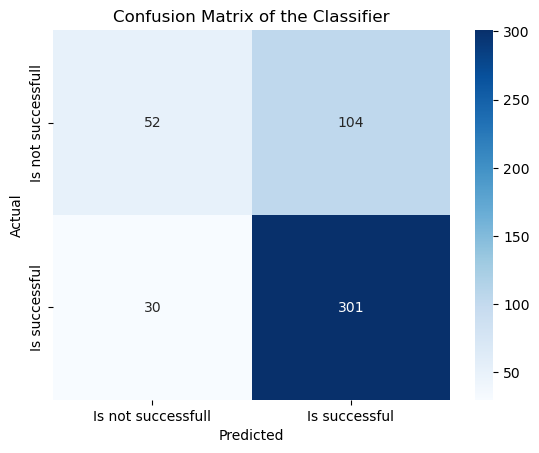

In [15]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = logreg_pred,
          labels = ['Is not successfull', 'Is successful'])

<h2>Classification Trees (CART Models)</h2><br>

Moving on to the next step, we have the CART models. In the project, I utilized a pruned decision tree and a pruned random forest.

In [16]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

<h3>Decision Tree.</h3>
For the decision tree, I used the argumerns max depth of 2, a minimum sample leaf of 3 and the same random state as before(219).

In [17]:
#Control

# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth=        2,
                                     min_samples_leaf= 3,
                                     random_state=     219) 

# FITTING the training data
pruned_tree_fit = pruned_tree.fit(x_train, y_train)

# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)

# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy
pruned_tree_gap         = abs(pruned_tree_train_score - pruned_tree_test_score).round(4)
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,y_score = pruned_tree_pred).round(4) # auc

# SCORING the model
print('Pruned Tree Training ACCURACY:', pruned_tree_fit.score(x_train,y_train).round(4))
print('Pruned Tree Testing ACCURACY :', pruned_tree_fit.score(x_test,y_test).round(4))
print('Model GAP                    :', abs(pruned_tree_train_score - pruned_tree_test_score).round(4))
print('Pruned Tree AUC Score        :', roc_auc_score(y_true  = y_test, y_score = pruned_tree_pred).round(4))



Pruned Tree Training ACCURACY: 0.7238
Pruned Tree Testing ACCURACY : 0.7269
Model GAP                    : 0.0031
Pruned Tree AUC Score        : 0.6059


In [18]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred ).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 42
False Positives: 114
False Negatives: 19
True Positives : 312



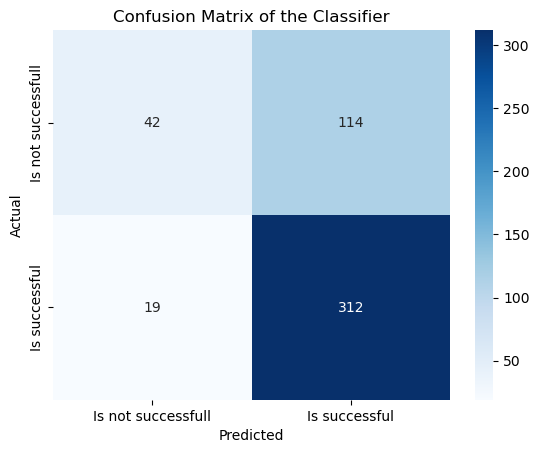

In [19]:
visual_cm(true_y = y_test,
          pred_y = pruned_tree_pred,
          labels = ['Is not successfull', 'Is successful'])

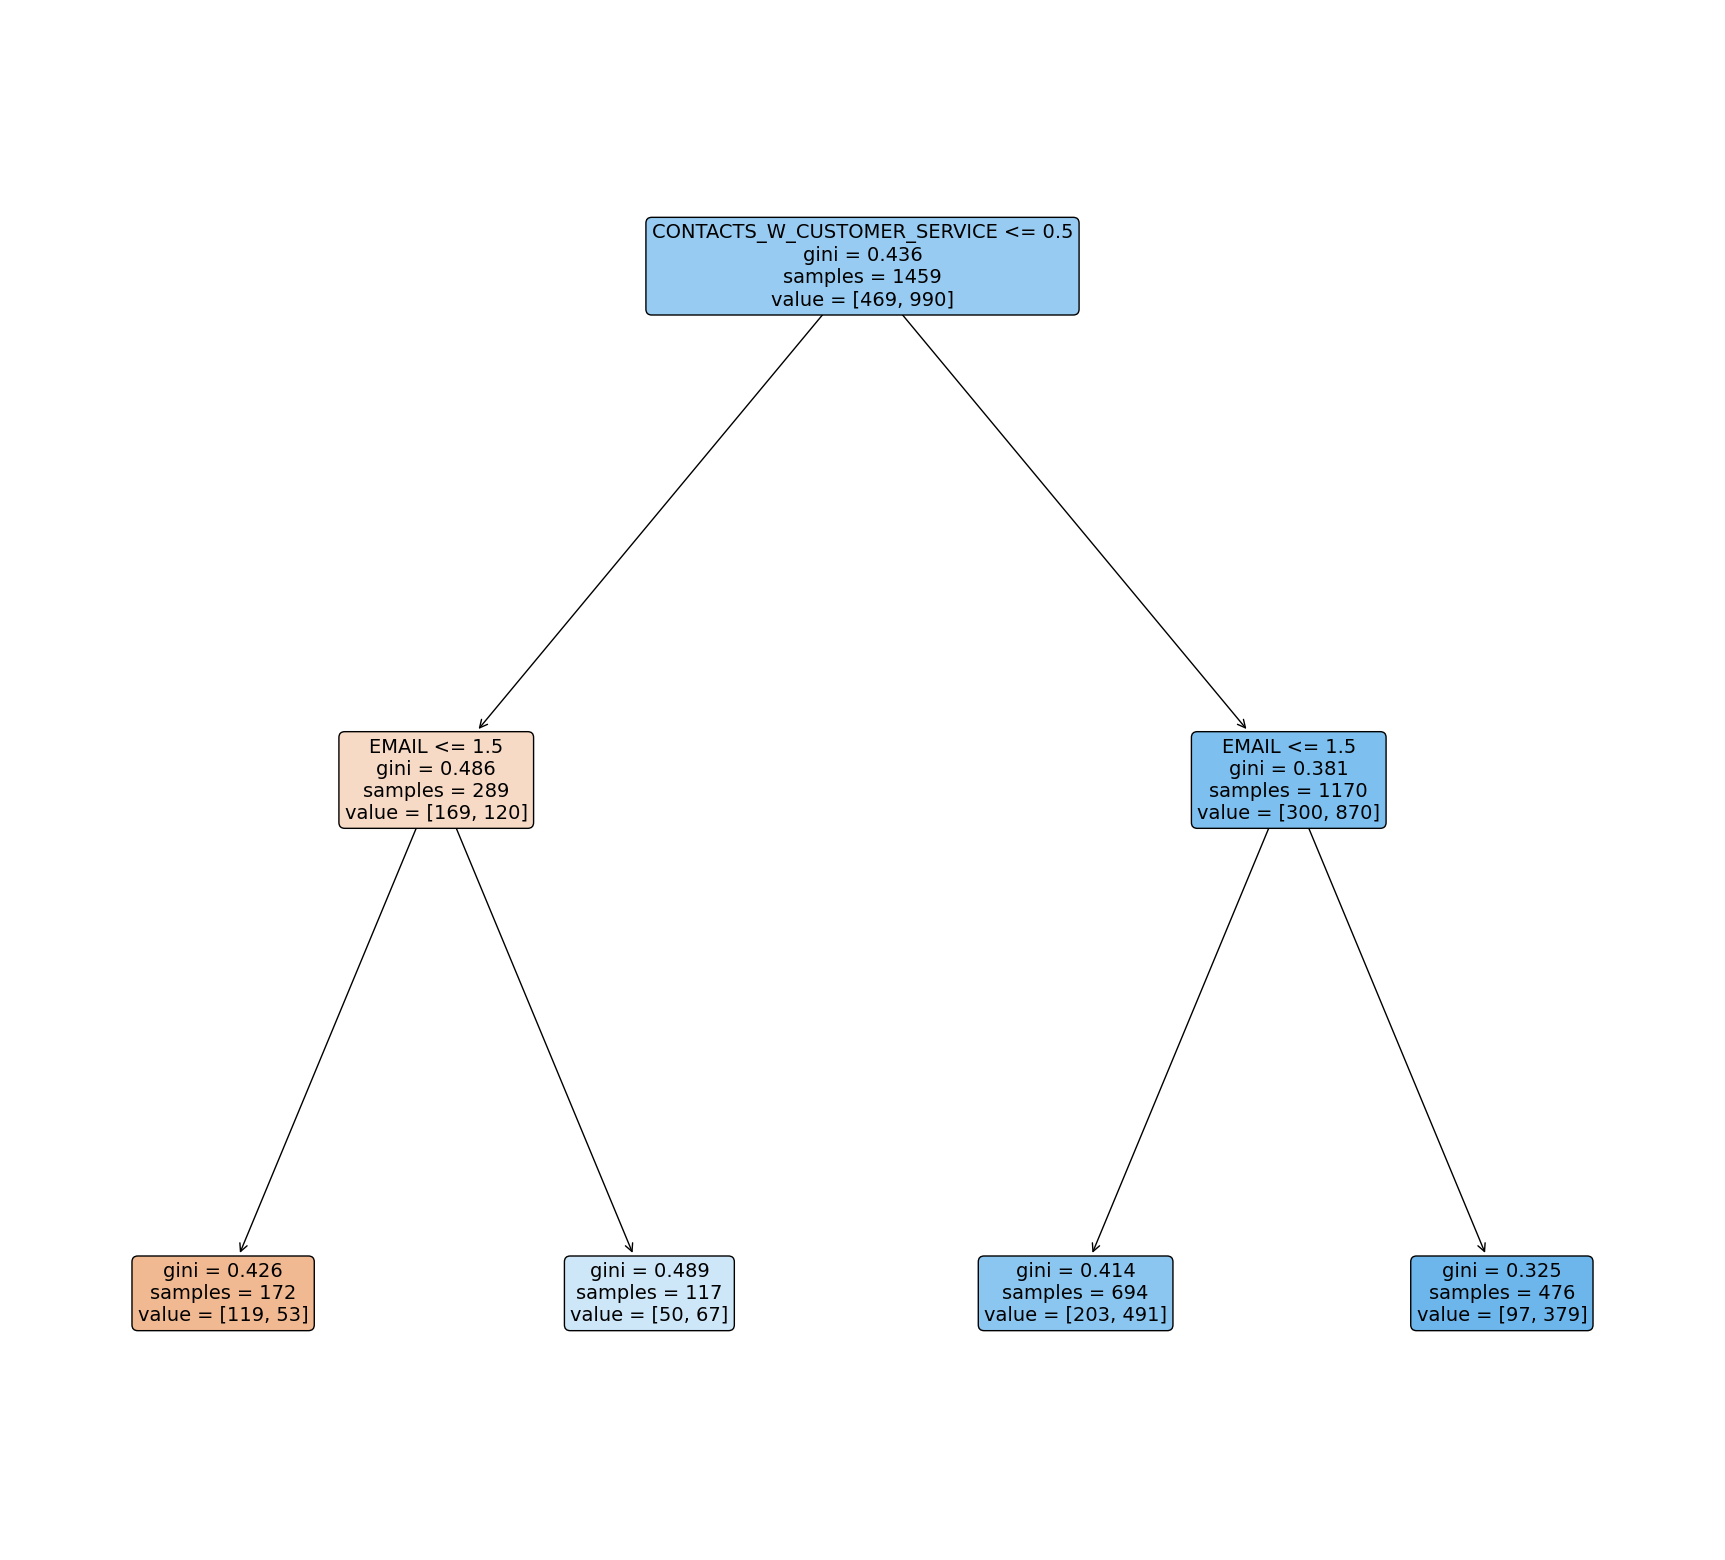

In [20]:
# setting figure size
plt.figure(figsize=(22,20))


# developing a plotted tree
plot_tree(decision_tree = pruned_tree_fit, 
          feature_names = apprentice.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)


# rendering the plot
plt.show()

<h2>Random Forest.</h2>
For the Random Forest, I used the argumerns  n estimator on 220, a max depth of 2, a minimum sample leaf of 70 and the same random state as before(219).

Since this was the best model I got so far, I decided to run different tests to see how each change was affecting the outcome. When I increased the number for the n estimator, my accuracy increased but plato at 200. The depth started at 7 but lowering increased my AUC and the sample leaf helped me decrease the gap between the train and test scores. 

After some investigation, I found that random forest doesn’t really care about correlation between the columns but rather the trend generated by the different trees to get an average, something that in this case is causing a problem with the accuracy lowering it to just 10%. But again, accuracy is a measure we use to guide our analysis.

In [21]:
#Control

# INSTANTIATING a classification tree object
random_forest = RandomForestRegressor(n_estimators     = 220,
                                      criterion        = 'squared_error',
                                      max_depth        = 2,
                                      min_samples_leaf = 70,
                                      bootstrap        = True,
                                      warm_start       = False,
                                      random_state     = 219)


# FITTING the training data
random_forest_fit = random_forest.fit(x_train, y_train)


# PREDICTING on new data
random_forest_pred = random_forest_fit.predict(x_test)


# saving scoring data for future use
random_forest_train_score = random_forest_fit.score(x_train, y_train).round(4) # accuracy
random_forest_test_score  = random_forest_fit.score(x_test, y_test).round(4)   # accuracy
random_forest_gap         = abs(random_forest_train_score - random_forest_test_score).round(4)
random_forest_auc_score   = roc_auc_score(y_true  = y_test,y_score = random_forest_pred).round(4) # auc


# SCORING the model
print('Random forest Training ACCURACY:', random_forest_fit.score(x_train, y_train).round(4))
print('Random forest Testing ACCURACY :', random_forest_fit.score(x_test, y_test).round(4))
print('Model GAP                      :', abs(random_forest_train_score - random_forest_test_score).round(4))
print('Random forest AUC Score        :', roc_auc_score(y_true  = y_test, y_score = random_forest_pred).round(4))


# Random forest Training ACCURACY: 0.1061 (200 2 70)
# Random forest Testing ACCURACY : 0.1071
# Model GAP                      : 0.001
# Random forest AUC Score        : 0.6833


Random forest Training ACCURACY: 0.1062
Random forest Testing ACCURACY : 0.1073
Model GAP                      : 0.0011
Random forest AUC Score        : 0.6839


In [22]:
#print(random_forest_pred)

r_f_pred_50 = []

for prediction in random_forest_pred:
    
    if prediction > 0.5 : 
        r_f_pred_50.append(1) 
    else:
        r_f_pred_50.append(0) 
        

In [23]:
#ONES and Zeros

#unpacking the confusion matrix
random_forest_tn, \
random_forest_fp, \
random_forest_fn, \
random_forest_tp = confusion_matrix(y_true = y_test, y_pred = r_f_pred_50 ).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {random_forest_tn}
False Positives: {random_forest_fp}
False Negatives: {random_forest_fn}
True Positives : {random_forest_tp}
""")



True Negatives : 42
False Positives: 114
False Negatives: 19
True Positives : 312



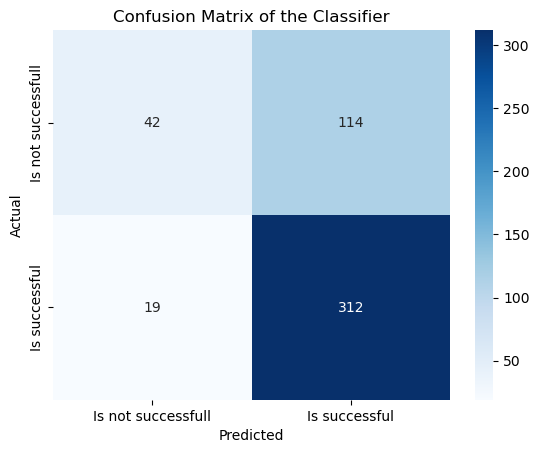

In [24]:
visual_cm(true_y = y_test,
          pred_y = r_f_pred_50,
          labels = ['Is not successfull', 'Is successful'])

<h2>Gradient Boosting.</h2>

For the Gradient Boosting, I used the argumerns max depth of 3 , n estimatorand of 90 and the same random state as before(219).

The result of this model gives us a similar outcome to the logistic regression but the gap is much worse therefore I decided to leave it aside and not use it as my best model. 



In [25]:
#Control


# INSTANTIATING a classification tree object
gradient_boosting = GradientBoostingClassifier(n_estimators= 90,
                                               max_depth= 3,
                                               random_state   = 219) #max_depth = 3


# FITTING the training data
gradient_boosting_fit = gradient_boosting.fit(x_train, y_train)


# PREDICTING on new data
gradient_boosting_pred = gradient_boosting_fit.predict(x_test)


# saving scoring data for future use
gradient_boosting_train_score = gradient_boosting_fit.score(x_train, y_train).round(4) # accuracy
gradient_boosting_test_score  = gradient_boosting_fit.score(x_test, y_test).round(4)   # accuracy
gradient_boosting_gap         = abs(gradient_boosting_train_score - gradient_boosting_test_score).round(4)
gradient_boosting_auc_score   = roc_auc_score(y_true  = y_test, y_score = gradient_boosting_pred).round(4) # auc

# SCORING the model
print('Gradient Boosting Training ACCURACY:', gradient_boosting_fit.score(x_train, y_train).round(4))
print('Gradient Boosting Testing ACCURACY :', gradient_boosting_fit.score(x_test, y_test).round(4))
print('Model GAP                          :', abs(gradient_boosting_train_score - gradient_boosting_test_score).round(4))
print('Gradient Boosting AUC Score        :', roc_auc_score(y_true  = y_test, y_score = gradient_boosting_pred).round(4))   


Gradient Boosting Training ACCURACY: 0.7711
Gradient Boosting Testing ACCURACY : 0.7269
Model GAP                          : 0.0442
Gradient Boosting AUC Score        : 0.6229


In [26]:
gradient_boosting_tn, \
gradient_boosting_fp, \
gradient_boosting_fn, \
gradient_boosting_tp = confusion_matrix(y_true = y_test, y_pred = gradient_boosting_pred ).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gradient_boosting_tn}
False Positives: {gradient_boosting_fp}
False Negatives: {gradient_boosting_fn}
True Positives : {gradient_boosting_tp}
""")


True Negatives : 52
False Positives: 104
False Negatives: 29
True Positives : 302



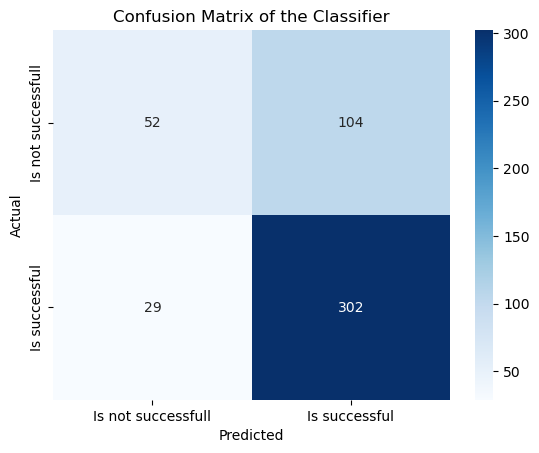

In [27]:
visual_cm(true_y = y_test,
          pred_y = gradient_boosting_pred,
          labels = ['Is not successfull', 'Is successful'])

<h2>KNeighbors.</h2>

KNeigbors is the last model tested but also the one with the closet score, it finds the predictions and clusters them into the categories based on proximetry. The optimal number of neighbors it generated was 13  but the AUC was below .60 after using standard scaler.


In [28]:
########################################
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1

c:\Users\SnowG\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\SnowG\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

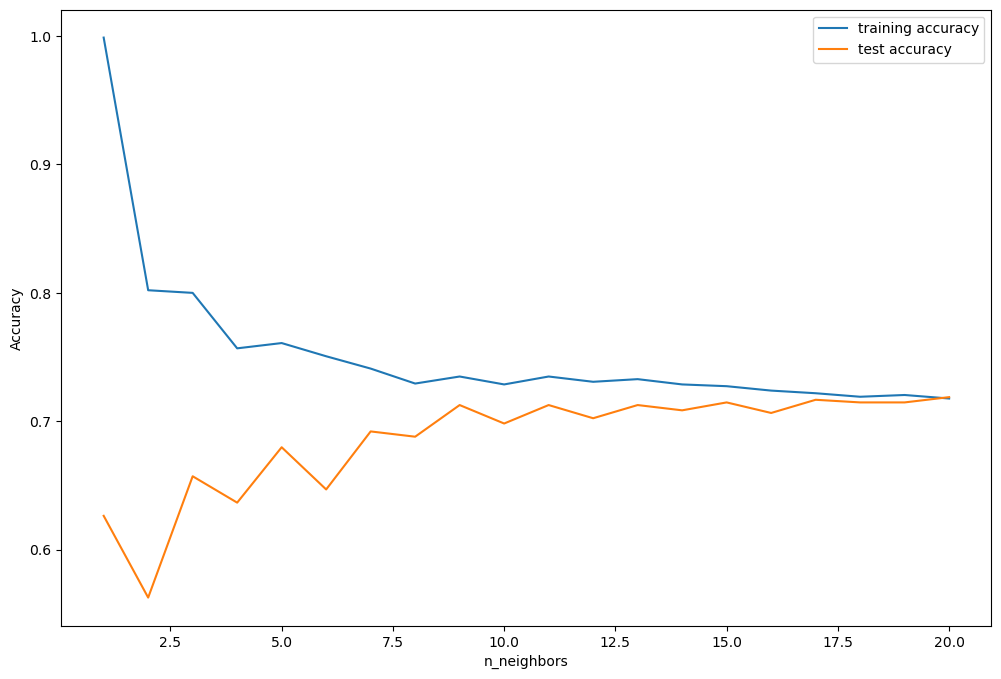

The optimal number of neighbors is: 20


In [29]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = apprentice_data,
                                  y_data        = apprentice_target,
                                  response_type = 'class')

In [30]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(apprentice_data)


# TRANSFORMING the data
x_scaled     = scaler.transform(apprentice_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 


# train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            apprentice_target,
            random_state = 219,
            test_size    = 0.25,
            stratify     = apprentice_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)


# saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)
knn_gap         = abs(knn_test_score).round(4)
knn_auc_score   = roc_auc_score(y_true  = y_test, y_score = knn_pred).round(4)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('Model GAP        :', abs(knn_train_score - knn_test_score).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test, y_score = knn_pred).round(4))




Training ACCURACY: 0.7313
Testing  ACCURACY: 0.6879
Model GAP        : 0.0434
AUC Score        : 0.5925


c:\Users\SnowG\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\SnowG\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [31]:
# unpacking the confusion matrix
knn_tn, \
knn_fp, \
knn_fn, \
knn_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_tn}
False Positives: {knn_fp}
False Negatives: {knn_fn}
True Positives : {knn_tp}
""")


True Negatives : 51
False Positives: 105
False Negatives: 47
True Positives : 284



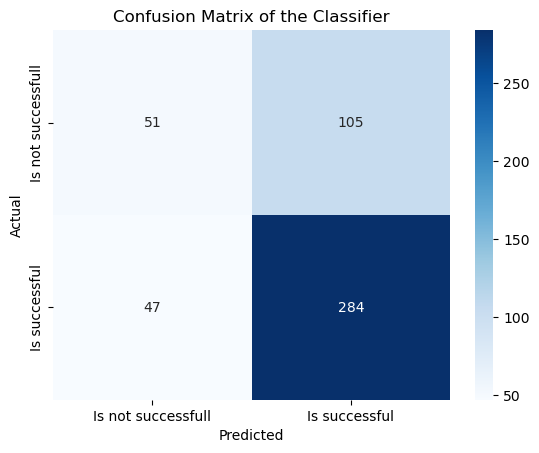

In [32]:
visual_cm(true_y = y_test,
          pred_y = knn_pred,
          labels = ['Is not successfull', 'Is successful'])

<h2>Comparison</h2>

Finally, we reach the point where we can compare between the 5 different models we run for the case:


This table shows the different machine learning models by their AUC Score  (a measure of how well each model performed in terms of its ability to correctly classify the data) The TN, FP, FN, and TP values are the true negatives, false positives, false negatives, and true positives, respectively, for each model. These values indicate how many instances of each type were correctly or incorrectly classified by each model. Overall, this information suggest that the Random Forest model performed the best with an AUC Score of 0.6839, while the KNeighbors model performed the worst with an AUC Score of 0.5925. 

In [33]:
# comparing results
print(f"""
Model              AUC Score       TN, FP, FN, TP
-----              ---------       --------------
Logistic           {logreg_auc_score}          {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Decision Tree      {pruned_tree_auc_score}          {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
Random Forest      {random_forest_auc_score}          {random_forest_tn, random_forest_fp, random_forest_fn, random_forest_tp}        
Gradient Boosting  {gradient_boosting_auc_score}          {gradient_boosting_tn, gradient_boosting_fp, gradient_boosting_fn, gradient_boosting_tp}    
KNeighbors         {knn_auc_score}          {knn_tn, knn_fp, knn_fn, knn_tp}

""")
#                                               
#Decision Tree   {pruned_tree_auc_score}         

# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic','Pruned Tree', 'Random Forest', 'Gradient Boosting', 'KNeighbors'],
           
    'AUC Score' : [logreg_auc_score, pruned_tree_auc_score, 
                   random_forest_auc_score, gradient_boosting_auc_score,
                   knn_auc_score],
    
    'Training Accuracy' : [logreg_train_score, pruned_tree_train_score,
                          random_forest_train_score, gradient_boosting_train_score,
                          knn_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, pruned_tree_test_score,
                          random_forest_test_score, gradient_boosting_test_score,
                          knn_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                           (random_forest_tn, random_forest_fp, random_forest_fn, random_forest_tp),
                           (gradient_boosting_tn, gradient_boosting_fp, gradient_boosting_fn, gradient_boosting_tp),    
                           (knn_tn, knn_fp, knn_fn, knn_tp)]
}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


Model              AUC Score       TN, FP, FN, TP
-----              ---------       --------------
Logistic           0.6213          (52, 104, 30, 301)
Decision Tree      0.6059          (42, 114, 19, 312)
Random Forest      0.6839          (42, 114, 19, 312)        
Gradient Boosting  0.6229          (52, 104, 29, 302)    
KNeighbors         0.5925          (51, 105, 47, 284)




<h2>Best model</h2>

The model I have decided to use for the final model is the Random Forest with a AUC score of 0.6839 despite having a low accuracy test, this based on the way the model works to generate the predictions. 

Another important factor to consider is the gap between the training and testing performance of the model. In this case, the gap is minimal with only a difference of 0.0011 between the two, indicating that the model is not overfitting on the training data and is likely to generalize well to new data.

To conclude, it's worth noting that the values for TN, FP, FN, and TP for the Random Forest model have a similar proportion to those of other models with higher accuracy scores. This suggests that the model is performing reasonably well in terms of correctly identifying true positives and negatives, while minimizing false positives and false negatives. Overall, based on these considerations, the Random Forest model appears to be a strong choice for the final model in this classification project with chef apprentice. 


In [34]:
print(f"""
Model              AUC Score       TN, FP, FN, TP      Train Score    Test Score     GAP
-----              ---------       --------------      -----------    ----------     ---
Random Forest      {random_forest_auc_score}        {random_forest_tn, random_forest_fp, random_forest_fn, random_forest_tp}       {random_forest_train_score}        {random_forest_test_score}      {random_forest_gap}


""")


Model              AUC Score       TN, FP, FN, TP      Train Score    Test Score     GAP
-----              ---------       --------------      -----------    ----------     ---
Random Forest      0.6839        (42, 114, 19, 312)       0.1062        0.1073      0.0011



